In [1]:
import numpy as np
import math
class gen_samples:
    def __init__(self, pi, mu, C, dim):
        self.X = list()
        self.pi = pi
        self.mu = mu
        self.C = C
        self.dim = dim
        return
    def generate_samples(self, n_samples):
        iter = 1
        while(iter <= n_samples):
            z_i = np.argmax(np.random.multinomial(1, self.pi))
            sample = np.random.multivariate_normal(self.mu[z_i], self.C[z_i], 1)
            self.X.extend(sample)
            iter += 1
        return

In [2]:
pi = [1/2,1/3,1/3]
mu = [[10,0],[0,5],[-10,-10]]
C = [[[0.5,0],[0,0.5]],[[0.5,0],[0,0.5]],[[0.5,0],[0,0.5]]]
sample_run = gen_samples(pi,mu,C,2)

In [3]:
sample_run.generate_samples(1000)

In [4]:
import matplotlib.pyplot as plt
def plot_samples_2d(data):
    # Plotting the samples
    x_values = [point[0] for point in data]
    y_values = [point[1] for point in data]
    plt.scatter(x_values, y_values, label='Sample Points', color='blue')
    # Adding labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('2D Sample Plot')
    # Adding a legend
    plt.legend()
    # Display the plot
    plt.show()

def plot_samples_1d(data):
    sample_data_1d = [point[0] for point in data]
    # Plotting the histogram of 1D samples
    plt.hist(sample_data_1d, bins=100, color='blue', edgecolor='black', alpha=0.7)

    # Adding labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Frequency')
    plt.title('1D Sample Histogram')

    # Display the plot
    plt.show()
    return

def plot_generated_samples(data):
    if(len(data[0])==1):
        plot_samples_1d(data)
    if(len(data[0])==2):
        plot_samples_2d(data)
    return

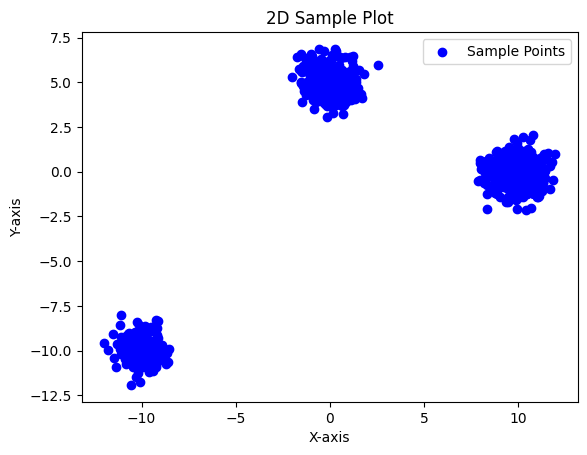

In [5]:
plot_generated_samples(sample_run.X)

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import numpy as np
import math
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA

class igmm:
    def __init__(self, X, dim, sigma_ini, tau, dbscan_eps, dbscan_min_samples, cluster_threshold):
        self.X = X
        self.dim = dim
        self.pi = []
        self.mu = []
        self.C = []
        self.sp = []
        self.sigma_ini = sigma_ini
        self.tau = tau
        self.outlier_set = []  # New list to store outlier data points
        self.dbscan_eps = dbscan_eps
        self.dbscan_min_samples = dbscan_min_samples
        self.cluster_threshold = cluster_threshold
        self.current_cluster = []
        
    def posterior_prob(self, x, component):
        mvn = multivariate_normal(mean=np.array(self.mu[component]), cov=np.array(self.C[component]))
        pdf_value = mvn.pdf(x)
        return self.pi[component] * pdf_value
    
    def createnewornot(self, x):
        createnew = True
        for i in range(len(self.pi)):
            novelty_criterion = self.tau / (((2 * math.pi) ** (self.dim / 2)) * math.sqrt(np.linalg.det(np.array(self.C[i]))))
            mvn = multivariate_normal(mean=self.mu[i], cov=np.array(self.C[i]))
            pdf_value = mvn.pdf(x)
            if pdf_value >= novelty_criterion:
                createnew = False
                return createnew
        return createnew
    
    def update_existing_components(self, x):
        #print("Components getting updated")
        for j in range(len(self.sp)):
            posterior_value = self.posterior_prob(x, j)
            self.sp[j] += posterior_value
            prev_mu = self.mu[j]
            self.mu[j] = self.mu[j] + (posterior_value / self.sp[j]) * (np.array(x) - self.mu[j])
            self.C[j] = self.C[j] - np.matmul((self.mu[j] - prev_mu), (self.mu[j] - prev_mu).T) + (posterior_value / self.sp[j]) * (np.matmul((np.array(x) - self.mu[j]),(np.array(x) - self.mu[j]).T) - self.C[j])
        total_sum = np.sum(self.sp)
        for j in range(len(self.pi)):
            self.pi[j] = self.sp[j] / total_sum
    
    def add_new_component(self, x):
        # Use the EM algorithm to estimate parameters
        gmm = GaussianMixture(n_components=1, covariance_type='full')
        gmm.fit(self.current_cluster)
        new_mu = gmm.means_[0]
        new_covariance_matrix = gmm.covariances_[0]
        new_weight = gmm.weights_[0]

        self.mu.append(new_mu)
        self.C.append(new_covariance_matrix)
        self.sp.append(len(self.current_cluster))
        total_sum = np.sum(self.sp)
        for j in range(len(self.sp) - 1):
            self.pi[j] = self.sp[j] / total_sum
        self.pi.append(self.sp[len(self.sp) - 1] / total_sum)
    
    def update(self, x):
        createnew = self.createnewornot(x)
        if createnew:
            #print("Creating new and appending to outlier")
            # Store the data point in the outlier set
            self.outlier_set.append(x)
            
            # Periodically perform DBSCAN clustering after the arrival of every 100 data points
            if len(self.outlier_set) >= 10:
                #print("Check for the outliers is being performed")
                self.perform_dbscan()
        else:
            #print("Not creating new and updating components")
            self.update_existing_components(x)
    
    def perform_dbscan(self):
        if len(self.outlier_set) >= self.dbscan_min_samples:
            # Convert the outlier set to a NumPy array
            outlier_data = np.array(self.outlier_set)
            
            # Apply DBSCAN clustering
            dbscan = DBSCAN(eps=self.dbscan_eps, min_samples=self.dbscan_min_samples)
            labels = dbscan.fit_predict(outlier_data)
            
            # Check for clusters with a number of points above the threshold
            for cluster_label in np.unique(labels):
                cluster_points = outlier_data[labels == cluster_label]
                if len(cluster_points) > self.cluster_threshold * len(self.X):
                    # Remove points from the outlier set
                    #print("Cluster in the outliers found")
                    self.current_cluster = cluster_points
                    self.outlier_set = [point for point in self.outlier_set if point not in cluster_points]
                    
                    # For each point, check the novelty criterion and update accordingly
                    for point in cluster_points:
                        if self.createnewornot(point):
                            #print("Outlier point is forming a new component")
                            # If the point meets the novelty criterion, update existing components
                            self.add_new_component(point)
                        else:
                            # If the point doesn't meet the novelty criterion, add a new component
                            #print("Outlier point is getting updated in the components")
                            self.update_existing_components(point)
    
    def fit(self):
        for x in self.X:
            self.update(x)
            print_pi = np.array(self.pi)
            print_mean = np.array(self.mu)
            print_cov = np.array(self.C)
            print_sp = np.array(self.sp)
        return

In [7]:
sample_run.X
data = sample_run.X

In [10]:
prototype_run = igmm(X=data, dim=2, sigma_ini=1.0, tau=0.01, dbscan_eps=0.5, dbscan_min_samples=10, cluster_threshold=0.1)

In [11]:
prototype_run.fit()

In [13]:
prototype_run.mu

[array([9.89316598, 0.03247114]),
 array([0.06432597, 4.93175514]),
 array([-9.95097741, -9.93988608])]